In [6]:
import numpy as np
from datetime import timedelta
import os, sys
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

notebook_path = os.getcwd()
print(notebook_path)
sys.path.append(os.path.join(notebook_path, '..', '..'))
from studies.flair import Flair

/Users/jan/git/nudgebg/egvinsulin/notebooks/understand-flair-dataset


# TDD

In [7]:
study_dataset_path = os.path.join(notebook_path, '..','..', 'data', 'raw', 'FLAIRPublicDataSet')
flair = Flair('Flair', study_dataset_path)
flair.load_data();

In [8]:
basal = flair.extract_basal_event_history()
bolus = flair.extract_bolus_event_history()

Now we calculate TDD, once based on the extracted basal and bolus information (calculated) and once on the reported TDD of the flair data (reported)

In [9]:
def calculate_tdd_basals(df):
    #add support points around midnight 
    start_date = df.datetime.min().date()
    end_date = df.datetime.max().date()
    dates = pd.date_range(start_date, end_date+pd.Timedelta(days=1), freq='D')
    supports = (dates-timedelta(microseconds=1)).append(dates+timedelta(microseconds=1))[1::]
    df = pd.concat([df, pd.DataFrame({'datetime': supports})]).sort_values(by='datetime').reset_index(drop=True)
    df['basal_rate'] = df.basal_rate.ffill()
    
    date = df.datetime.dt.date; date.name = 'date'
    tdds = df.groupby(date).apply(lambda group: np.trapz(group['basal_rate'], (group.datetime-group.datetime.min()).dt.total_seconds()/3600))
    tdds.name = 'basal'
    return tdds

def extract_TDDs():
    tdds_flair = flair.df_pump.dropna(subset=['TDD'])[['PtID','DateTime','TDD']]
    tdds_flair['DateTime'] = tdds_flair.DateTime.dt.date
    tdds_flair['PtID'] = tdds_flair.PtID.astype(str)
    tdds_flair = tdds_flair.rename(columns={'PtID':'patient_id','DateTime':'date','TDD':'tdd'})
    return tdds_flair

#calculate basal tdd
tdd_basals = pd.DataFrame(basal.groupby(basal.patient_id).apply(calculate_tdd_basals))
#display(tdd_basals.head())

#calcualte bolus tdd
date = bolus.datetime.dt.date
date.name='date'
tdd_boluses = bolus.groupby(['patient_id',date]).agg({'bolus':'sum'})
#display(tdd_boluses.head())

#combine bolus and basal tdds
tdds_calculated = pd.merge(tdd_boluses ,tdd_basals, left_index=True, right_index=True, suffixes=['_bolus','_basal'])
tdds_calculated['tdd'] = tdds_calculated.bolus + tdds_calculated.basal

#get reported tdd 
tdd_reported = extract_TDDs().set_index(['patient_id','date'])
tdd_reported.name = 'reported'

#combine dataframes and scatter plot
TDDs = pd.merge(tdds_calculated, tdd_reported, left_index=True, right_index=True, suffixes=['_calculated','_reported'])
display(TDDs)

bolus      basal  tdd_calculated  tdd_reported
patient_id date                                                      
1          2018-08-08  16.50        NaN             NaN        28.875
           2018-08-09  26.00  21.464583       47.464583        50.825
           2018-08-10  16.10  18.115944       34.215944        46.250
           2018-08-11  17.80  15.053125       32.853125        42.300
           2018-08-12  28.50  19.273958       47.773958        54.100
...                      ...        ...             ...           ...
99         2019-02-28  43.97  29.217417       73.187417        43.125
           2019-03-01  44.28  18.186778       62.466778        43.575
           2019-03-02  53.91  17.432139       71.342139        53.150
           2019-03-03  44.47  32.462694       76.932694        44.500
           2019-03-04  47.74  25.255222       72.995222        50.350

[25263 rows x 4 columns]

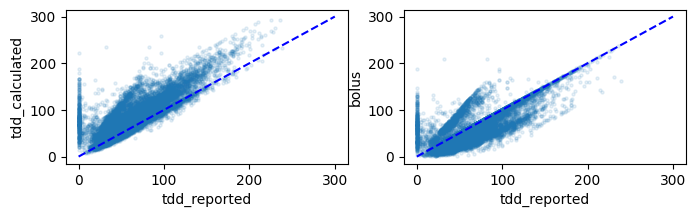

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
TDDs.plot.scatter(x='tdd_reported', y='tdd_calculated', marker='.', alpha=0.1, ax=axs[0])
axs[0].plot([0, 300], [0, 300], 'b--')
TDDs.plot.scatter(x='tdd_reported', y='bolus', marker='.', alpha=0.1, ax=axs[1])
axs[1].plot([0, 300], [0, 300], 'b--')

What we see is that the 
* calcualted tdds differ significantly from the extracted tdds 
* mostly calculated TDDs are too hight

There are multiple clusters:
 * Many instances where the extracted TDD is zero
 * Many instances where the calcualted is higher what appears to be a linear offset
* When looking at the boluses only, some TDDs are still too high.

Potential explanation for this: Potentiually the algorithm was switched and reported basal-rates were not actually delivered. Therefore, let's visualize reported basal rates by date.

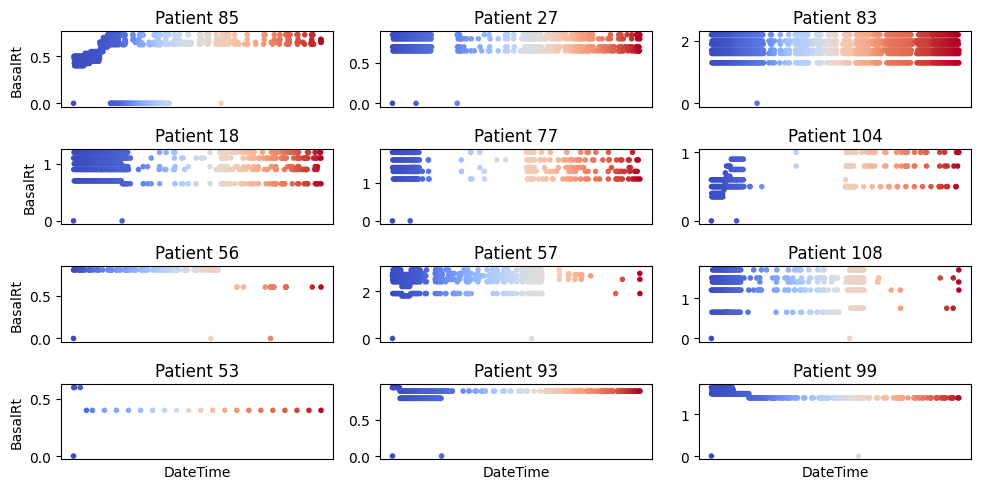

In [11]:
patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]
#patient_ids = np.random.choice(np.unique(flair.df_pump.PtID.unique()),8, replace=False)
fig, axs = plt.subplots(4,3, figsize=(10, 5)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    subFrame = flair.df_pump.loc[flair.df_pump.PtID == patient_id]#.dropna(subset=['BasalRt'])
    axs[i].scatter(subFrame['DateTime'], subFrame['BasalRt'], c=range(len(subFrame)), cmap='coolwarm', marker='.')
    axs[i].set_title(f'Patient {patient_id}')
    #hide x ticks
    axs[i].set_xticks([])
    if i>=9:
        axs[i].set_xlabel('DateTime')
    if i%3==0:
        axs[i].set_ylabel('BasalRt')

plt.tight_layout()
plt.show()

1. First row: basal rates regularly change start to end
2. Second Row: basal rates changebut in the middle they are not reported or very infrequently
3. Third Row: Basal rates are first reported regularly, then stop or very rarely
4. Forth Row: Basal rates remain constant 

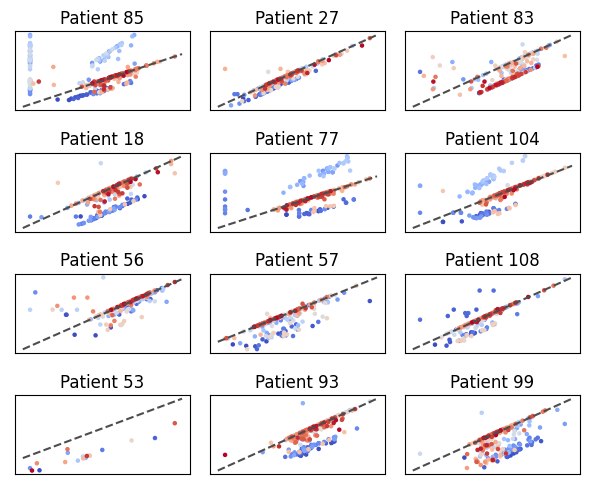

In [12]:
#scatter plot tdd_calcualted vs tdd_extracted for this patient
patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]

fig, axs = plt.subplots(4, 3, figsize=(6, 5)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    TDDs.loc[str(patient_id)].plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc[str(patient_id)])), cmap='coolwarm', marker='.', ax=axs[i])
    axs[i].set_title(f'Patient {patient_id}')
    #unity line
    axs[i].plot(axs[i].get_xlim(), axs[i].get_xlim(), ls="--", c=".3")
    #hide x and y ticks
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].set_xlabel(''); axs[i].set_ylabel('')
plt.tight_layout()
plt.show()

In order to understand what is really happening, we need to look at the study protocol and individuals. Let's start with patient 99 for which we know the bolus alsmost exactly matches TDD:


## Investigate Patient 99 more closely

We now investigate patient 99:

bolus             43.970000
basal             29.217417
tdd_calculated    73.187417
tdd_reported      43.125000
Name: 2019-02-28, dtype: float64

Text(0.5, 0.98, 'Patient 99')

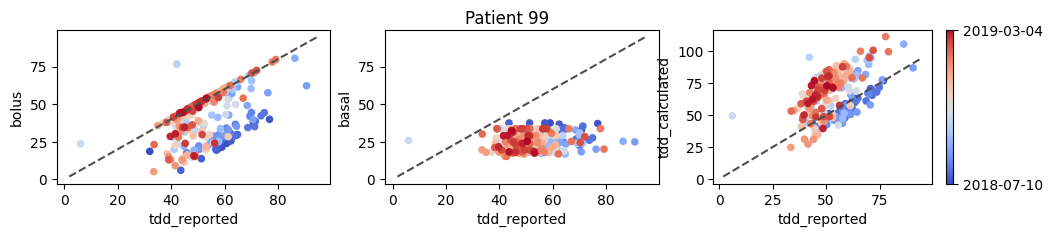

In [13]:
f, AX = plt.subplots(1,3, figsize=(12, 2))
display(TDDs.loc['99'].iloc[-5])
#scatter plot tdd_calcualted vs tdd_extracted for this patient
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[0])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='basal', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[1])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='tdd_calculated', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[2])

#add unity line with limits to the limits of the current axis
AX[0].plot(AX[0].get_xlim(), AX[0].get_xlim(), ls="--", c=".3")
AX[1].plot(AX[1].get_xlim(), AX[1].get_xlim(), ls="--", c=".3")
AX[2].plot(AX[2].get_xlim(), AX[2].get_xlim(), ls="--", c=".3")
#add a heatmap of the colors that we used for scatter plotting
# Add a heatmap of the colors that we used for scatter plotting
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=len(TDDs.loc['99'])))
cbar = plt.colorbar(sm)
cbar.set_ticks([0, len(TDDs.loc['99'])])  # Set ticks to start and end
cbar.set_ticklabels([TDDs.loc['99'].index.min(), TDDs.loc['99'].index.max()])  # Set tick labels to start and end dates
#title patient id
f.suptitle('Patient 99')

In [14]:
from datetime import datetime
#patient 99 date 2019-02-28
date = datetime(2019,2,28).date()
patient = 99
print(f"TDD for patient {patient} is {TDDs.tdd_reported.loc[str(patient),date].values[0]}")

#get the raw data subframe for that day
df = flair.df_pump.loc[(flair.df_pump.PtID==patient) & (flair.df_pump.DateTime.dt.date == date)]
print(f"Bolus delivered sum is {df.BolusDeliv.sum()}")

subBasals = basal.loc[(basal.patient_id == str(patient)) & (basal.datetime.dt.date == date)]
print(f"There are {len(df.dropna(subset=['BasalRt']))} basal events in the original dataframe but {len(subBasals)} in the extracted basal dataframe")
display(subBasals)

TDD for patient 99 is 43.125
Bolus delivered sum is 43.97
There are 0 basal events in the original dataframe but 2 in the extracted basal dataframe


,patient_id,datetime,basal_rate
2520575,99,2019-02-28 05:49:32,0.0
2520574,99,2019-02-28 06:15:39,1.4


As we can see, for this day there are no basals! So we must have an error in the basal forward filling. 

The original dataframe has no data but the extracted does. We see that the index 2520574 is in fact a suspend event. We probably used this to forward propagate the basal rate of the previous day. We see that no basal rates were reported after the 27th and we forward filled this for the suspends. This might have been wrong. It looks like this is the end of the dataframe.

In [21]:
# show row 2520574
flair.df_pump.loc[2520574]

PtID                                     99
DataDtTm               2/28/2019 6:15:39 AM
NewDeviceDtTm                           NaN
BasalRt                                 NaN
BasalRtUnKnown                        False
TempBasalAmt                            NaN
TempBasalType                           NaN
TempBasalDur                            NaN
BolusType                               NaN
BolusSelected                           NaN
BolusDeliv                              NaN
ExtendBolusDuration                     NaN
PrimeVolumeDeliv                        NaN
Suspend                      NORMAL_PUMPING
Rewind                                  NaN
BolusSource                             NaN
TDD                                     NaN
DateTime                2019-02-28 06:15:39
Name: 2520574, dtype: object